In [149]:
import cv2 as cv
import cv2
from PIL import Image
import numpy as np
#from google.colab.patches import cv2_imshow
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.measure import label
from sklearn.feature_extraction import image
import time

from skimage.transform import AffineTransform, warp
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import circle_perimeter, line
from skimage.feature import canny
from skimage import color
from skimage import io

In [19]:
def get_dial_patches(im):
    # This function expects a very specific image
    airspeed = im[0:350,500:800]
    tach = im[200:500,300:500]
    return airspeed, tach

#airspeed, tach = get_dial_patches(im)
#plt.imshow(airspeed)

In [5]:
def unwarp_image(im, t_inv):
    t_inv /= np.sqrt(np.linalg.det(t_inv)) / 1.5  # make it a bit bigger
    t_inv_full = np.array([[t_inv[0,0], t_inv[0,1], 0.],
                           [t_inv[1,0], t_inv[1,1], 0.],
                           [0.0,        0.0,        1.]])
    t = np.linalg.inv(t_inv_full)
    affine_tf = AffineTransform(matrix=t)
    unwarped = warp(im, affine_tf)
    return unwarped

In [77]:
def get_dial_ijr(im_unwarped):
    gray = color.rgb2gray(im_unwarped)
    edges = canny(gray, sigma=0.7, low_threshold=0.55, high_threshold=0.9)
    hough_radii = np.arange(50, 200, 1)
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, #min_xdistance=20, min_ydistance=20,
                                           total_num_peaks=1)
    circles = list(zip(cy, cx, radii))
    return circles[0]

In [84]:
def draw_circle(im, i, j, r):
    image = im.copy()
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220/255, 20/255, 20/255)
    return image

In [405]:
def shrink_im_to_circle(im, i, j, r):
    rowbounds = [i-r, i+r]
    colbounds = [j-r, j+r]
    smaller_im = im[rowbounds[0]:rowbounds[1], colbounds[0]:colbounds[1]]
    return smaller_im

In [6]:
img = Image.open('many_dials.jpg')

In [7]:
im = np.array(img)

In [20]:
airspeed, tach = get_dial_patches(im)

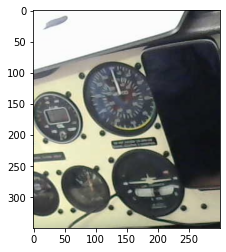

In [9]:
plt.imshow(airspeed)

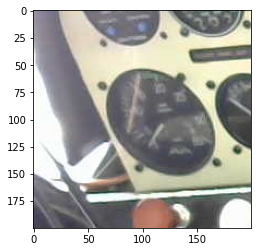

In [10]:
plt.imshow(tach)

In [63]:
t_inv_airspeed = np.array([[0.65, -.25], 
                           [0.1,   0.63]])

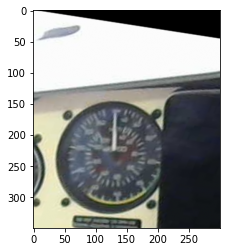

In [64]:
airspeed_unwarped = unwarp_image(airspeed, t_inv_airspeed)
plt.imshow(airspeed_unwarped)

In [395]:
airspeed_gray = color.rgb2gray(airspeed_unwarped)

In [396]:
airspeed_edges = canny(airspeed_gray, sigma=0.7,
              low_threshold=0.55, high_threshold=0.9)

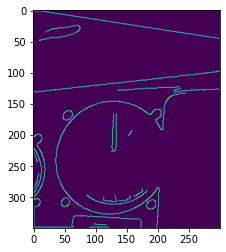

In [397]:
plt.imshow(airspeed_edges)

In [398]:
hough_radii = np.arange(50, 200, 1)
hough_res = hough_circle(airspeed_edges, hough_radii)

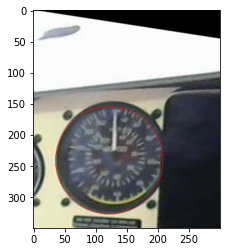

In [399]:
# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, #min_xdistance=20, min_ydistance=20,
                                           total_num_peaks=1)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
#image = color.gray2rgb(image)

image = airspeed_unwarped.copy()
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220/255, 20/255, 20/255)

ax.imshow(image)#, cmap=plt.cm.gray)
plt.show()

In [400]:
airspeed_circ = get_dial_ijr(airspeed_unwarped)

In [401]:
airspeed_circ

(241, 122, 86)

In [70]:
t_inv_tach = np.array([[0.68, -.32], 
                       [0.1,   0.6]])

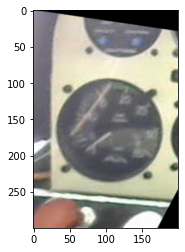

In [71]:
tach_unwarped = unwarp_image(tach, t_inv_tach)
plt.imshow(tach_unwarped)

In [218]:
tach_circ = get_dial_ijr(tach_unwarped)

In [219]:
tach_circ

(166, 105, 73)

In [85]:
tach_circle = draw_circle(tach_unwarped, *circ)

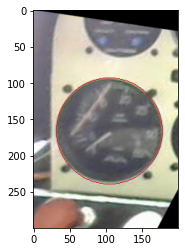

In [86]:
plt.imshow(tach_circle)

# test with airspeed

In [462]:
from importlib import reload
import image_analysis_for_testing as ia
reload(ia)

<module 'image_analysis_for_testing' from '/Users/DarcyMeyer/Documents/School/SeniorDesign/image-analysis/experiments/image_analysis_for_testing.py'>

In [463]:
sf = ia.SpeedFinder()

2 of 72 airspeed clusters are in the bounds and large


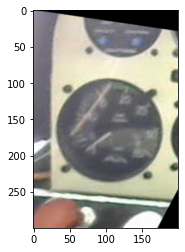

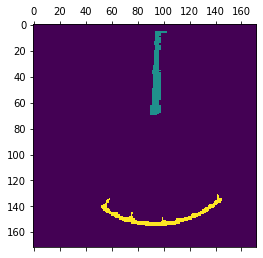

2 airspeed clusters gave out lines


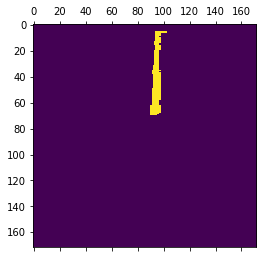

8 of 156 tach clusters are in the bounds and large


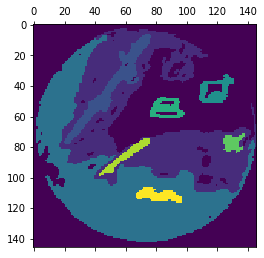

5 tach clusters gave out lines


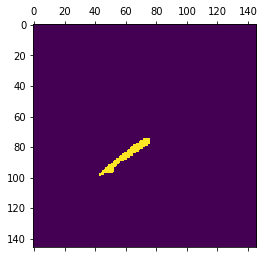

(10.597748309029795, 37.43183901294856)

In [464]:
sf.get_airspeed_and_tach(im)

In [213]:
i,j,r = airspeed_circ
userpoint = (i,j)
speed_over_angle = 90/(3.14159/2)
circle = airspeed_circ
sf.reset_config(userpoint, speed_over_angle, circle)

In [214]:
airspeed_small = shrink_im_to_circle(airspeed_unwarped, *airspeed_circ)

26 of 448 are in the bounds and large


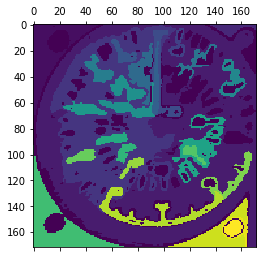

9 clusters gave out lines


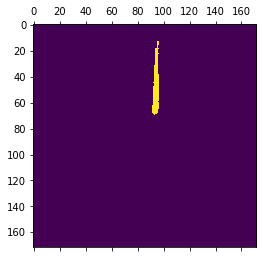

11.701240655021204

In [216]:
sf.get_speed(airspeed_unwarped)

In [324]:
i,j,r = tach_circ
userpoint = (i,j)
speed_over_angle = 90/(3.14159/2)
circle = tach_circ
sf.reset_config(userpoint, speed_over_angle, circle)

8 of 156 are in the bounds and large


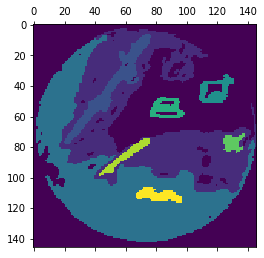

0 clusters gave out lines


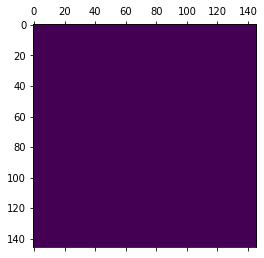

no lines found


In [325]:
sf.get_speed(tach_unwarped)

`>:(`

In [223]:
tach_small = shrink_im_to_circle(tach_unwarped, *tach_circ)

In [224]:
all_clusters, clusters, kmap, _ = sf.get_color_clusters(tach_small, n_clusters=4)

In [280]:
smaller_im_center = (int(tach_small.shape[0]/2), int(tach_small.shape[1]/2))

In [283]:
def is_cluster_in_circle(cluster, i, j, r):
    cluster_centered = cluster - [i,j]
    px_dists_sq = np.sum(np.power(cluster_centered, 2), axis=1)
    return np.max(px_dists_sq) <= r*r

In [284]:
filtered_clusters = [c for c in all_clusters if len(c) > 100 and is_cluster_in_circle(c, *smaller_im_center, smaller_im_center[0])]

dist was 103.23759005323593 r was 73
dist was 72.3671196055225 r was 73
dist was 82.87943049997388 r was 73
dist was 72.42237223399962 r was 73
dist was 66.03029607687671 r was 73
dist was 67.95586803212802 r was 73
dist was 31.89043743820395 r was 73
dist was 82.00609733428362 r was 73
dist was 64.00781202322104 r was 73
dist was 39.698866482558415 r was 73
dist was 87.96590248499699 r was 73
dist was 102.53292154230269 r was 73
dist was 101.82337649086284 r was 73
dist was 48.76474136094644 r was 73


In [281]:
is_cluster_in_circle(line_clusters[1], *smaller_im_center, smaller_im_center[0])

[[-70 -16]
 [-70 -15]
 [-70 -14]
 ...
 [ 36  59]
 [ 37  56]
 [ 37  57]]
dist was 72.3671196055225 r was 73


True

In [278]:
tach_small.shape

(146, 146, 3)

In [277]:
tach_circ

(166, 105, 73)

In [285]:
len(filtered_clusters)

8

In [140]:
def show_many_clusters(clusters, shape):
    arr = np.zeros(shape)
    for i, cluster in enumerate(clusters):
        for r,c in cluster:
            try:
                arr[r,c] = i+1
            except:
                pass
    plt.matshow(arr)
    plt.show()
    return arr

In [147]:
airspeed_small.shape

(172, 172, 3)

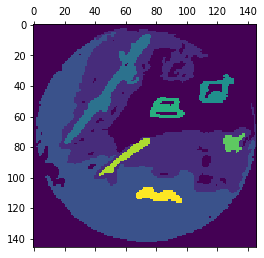

In [286]:
arr = show_many_clusters(filtered_clusters, tach_small.shape[:2])

In [320]:
edges_tach = canny(sf.cluster_to_img(filtered_clusters[6], tach_small.shape[:2]), sigma=0.7,
              low_threshold=0.55, high_threshold=0.9)

In [445]:
tach_gray = color.rgb2gray(tach_small)
edges_tach = canny(tach_gray, sigma=0.1,
              low_threshold=0.55, high_threshold=0.9)

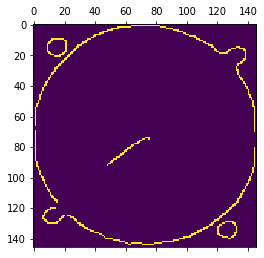

In [446]:
plt.matshow(edges_tach)

In [432]:
all_lines = []
line_clusters = []
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
for i, cluster in enumerate(filtered_clusters):
    #edges_tach = canny(sf.cluster_to_img(cluster, tach_small.shape[:2]), sigma=0.7,
    #          low_threshold=0.55, high_threshold=0.9)
    h, theta, d = hough_line(sf.cluster_to_img(cluster, tach_small.shape[:2]), theta=tested_angles)
    lines = list(zip(*hough_line_peaks(h, theta, d)))
    if lines[0][0] > 10:
        all_lines.append(lines)
        line_clusters.append(cluster)

In [433]:
len(all_lines)

8

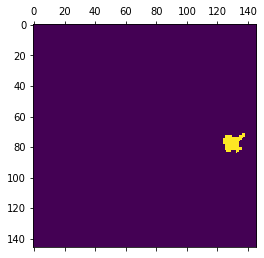

In [439]:
sf.show_cluster(line_clusters[5], tach_small.shape[:2])

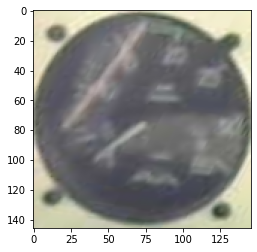

In [440]:
plt.imshow(tach_small)

In [435]:
smaller_im_center = (int(tach_small.shape[:2][0]/2), int(tach_small.shape[:2][1]/2))

In [436]:
smaller_im_center

(73, 73)

In [437]:
linenesses = [sf.lineness_metric(cluster, center=smaller_im_center)[0] for cluster in line_clusters]

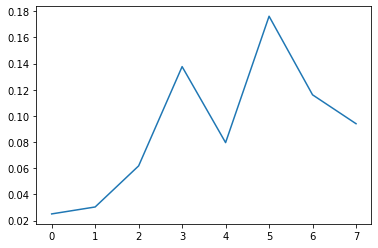

In [438]:
plt.plot(linenesses)

In [196]:
np.argmax(linenesses)

5

In [168]:
h.shape

(489, 360)

In [169]:
theta.shape

(360,)

In [170]:
d.shape

(489,)

In [403]:
airspeed_circ

(241, 122, 86)

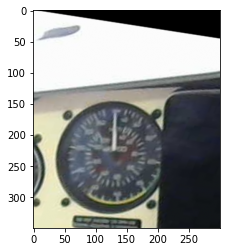

In [404]:
plt.imshow(airspeed_unwarped)

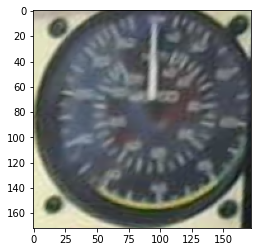

In [406]:
plt.imshow(shrink_im_to_circle(airspeed_unwarped, *airspeed_circ))

# abandon

In [427]:
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
airspeed_gray = color.rgb2gray(shrink_im_to_circle(airspeed_unwarped, *airspeed_circ))
edges_airspeed = canny(airspeed_gray, sigma=0.01,
              low_threshold=0.05, high_threshold=0.9)
h, theta, d = hough_line(edges_airspeed, theta=tested_angles)

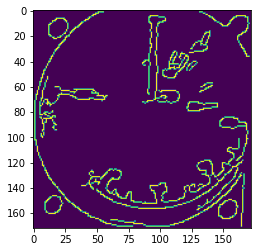

In [428]:
plt.imshow(edges_airspeed)

In [429]:
lines = list(zip(*hough_line_peaks(h, theta, d)))

In [125]:
lines

[(341, 0.7853981633974483, 122.0),
 (341, -0.7853981633974483, 1.0),
 (215, 1.0122909661567112, 91.0),
 (215, 0.5585053606381853, 91.0),
 (215, -0.5585053606381853, 52.0),
 (215, -1.0122909661567112, -50.0),
 (214, 1.1082840750163991, 140.0),
 (214, 0.4625122517784974, 140.0),
 (214, 1.1082840750163991, 122.0),
 (214, 0.4625122517784974, 122.0),
 (214, 1.1082840750163991, 97.0),
 (214, 0.4625122517784974, 97.0),
 (214, -0.4625122517784972, 61.0),
 (214, -0.4625122517784972, 48.0),
 (214, -0.4625122517784972, 27.0),
 (214, -0.4625122517784972, 14.0),
 (214, -1.1082840750163991, -5.0),
 (214, -1.1082840750163991, -18.0),
 (214, -1.1082840750163991, -48.0),
 (214, -1.1082840750163991, -61.0),
 (213, 1.1082840750163991, 152.0),
 (213, 0.4625122517784974, 152.0),
 (213, 1.1082840750163991, 110.0),
 (213, 0.4625122517784974, 110.0),
 (213, 1.1082840750163991, 76.0),
 (213, 0.4625122517784974, 76.0),
 (213, -0.4625122517784972, 73.0),
 (213, -1.1082840750163991, -73.0),
 (186, 1.3439035240356

In [430]:
display_img = airspeed_small.copy()
for _, angle, dist in lines[:10]:
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    slope = np.tan(angle + np.pi/2)
    #slope = np.tan(angle)
    linepx = line(int(x0), int(y0), int(x0+150), int(y0+150*slope))
    for x, y in zip(*linepx):
        try:
            display_img[x,y] = (255,0,0)
        except:
            pass

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


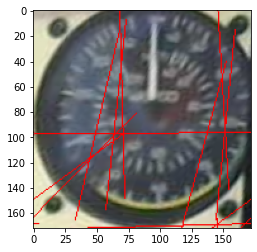

In [431]:
plt.imshow(display_img)

# new approach with tach -- abandon

In [414]:
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
tach_gray = color.rgb2gray(shrink_im_to_circle(tach_unwarped, *tach_circ))
edges_tach = canny(tach_gray, sigma=0.01,
              low_threshold=0.05, high_threshold=0.9)
h, theta, d = hough_line(edges_tach, theta=tested_angles)

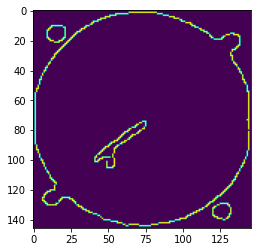

In [415]:
plt.imshow(edges_tach)

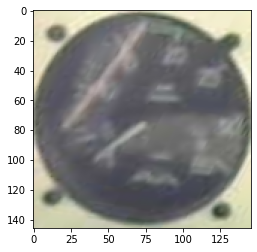

In [416]:
plt.imshow(shrink_im_to_circle(tach_unwarped, *tach_circ))

In [419]:
lines = list(zip(*hough_line_peaks(h, theta, d)))

In [420]:
lines[:5]

[(45, 0.9075712110370513, 102.0),
 (42, -0.02617993877991487, 142.0),
 (35, 0.02617993877991487, 3.0),
 (32, 1.1082840750163991, 25.0),
 (31, 0.8115781021773634, 31.0)]

In [423]:
display_img = edges_tach.copy()
for _, angle, dist in lines[:10]:
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    print(x0, y0)
    slope = np.tan(angle + np.pi/2)
    linepx = line(int(x0), int(y0), int(x0+150), int(y0+150*slope))
    for x, y in zip(*linepx):
        if x>=0 and y>=0:
            try:
                display_img[x,y] = (255,0,0)
            except:
                pass

62.797470483217154 80.37709686788564
141.95134014652913 -3.7171266597179766
2.998971974926672 0.07853084492361923
11.154945327745223 22.373359040050627
21.33899184650637 22.48660550138092
22.373359040050627 11.154945327745223
123.74368670764582 123.74368670764581
108.3175467749458 136.17381929232002
54.74432491433846 154.59320453911724
14.79163916092448 -31.72077254628275


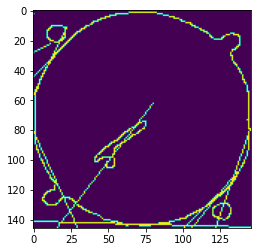

In [424]:
plt.imshow(display_img)